In [1]:
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import urllib.request
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download NLTK data files
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

In [2]:
my_data = 'https://raw.githubusercontent.com/Slimcent/Spam-Message-Detection/main/spam.csv'

def download_read_data(path):
    """
    Function to retrieve data from the data path
    And to read the data as a pandas dataframe
  
    To return the dataframe
    """ 
    # Only retrieve the directory of the data
    data_path = urllib.request.urlretrieve(path)[0]
    data = pd.read_csv(str(data_path), encoding='ISO-8859-1')

    return data

In [3]:
# Getting and loading the dataset
data = download_read_data(my_data)

In [4]:
# Change the column names
#df = pd.read_csv('spam.csv', encoding='latin-1')
df = data.rename(columns={'v1': 'category', 'v2': 'text'})
df = df[['category', 'text']]

Dataset description

In [5]:
# Display the first ten rows of the dataset
print(df.head(10))

  category                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...


In [6]:
# Display the last ten rows of the dataset
print(df.tail(10))

     category                                               text
5562      ham  Ok lor... Sony ericsson salesman... I ask shuh...
5563      ham                                Ard 6 like dat lor.
5564      ham  Why don't you wait 'til at least wednesday to ...
5565      ham                                       Huh y lei...
5566     spam  REMINDER FROM O2: To get 2.50 pounds free call...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham              Will Ì_ b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name


In [7]:
# Display basic statistics
print(df.describe())

       category                    text
count      5572                    5572
unique        2                    5169
top         ham  Sorry, I'll call later
freq       4825                      30


In [8]:
# Display dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   text      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [9]:
df.shape

(5572, 2)

Split the Data into Training and Test Sets

In [10]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, 
                                                    random_state=42, stratify=df['category'])

# Print the number of samples in the training and testing sets
print(f'The size of training data is: {X_train.shape[0]}')
print(f'The size of testing data is: {X_test.shape[0]}')

The size of training data is: 4457
The size of testing data is: 1115


Exploratory data analysis

In [11]:
# Display category distribution
print(df['category'].value_counts())

category
ham     4825
spam     747
Name: count, dtype: int64


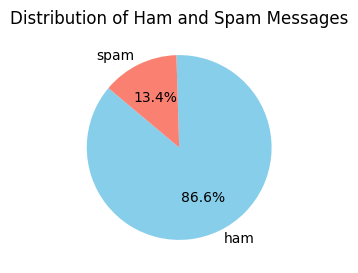

In [12]:
# Calculate the value counts and their percentage
value_counts = df['category'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Plot the pie chart
plt.figure(figsize=(5, 3))
plt.pie(percentages, labels=value_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=140)
plt.title('Distribution of Ham and Spam Messages')
plt.show()

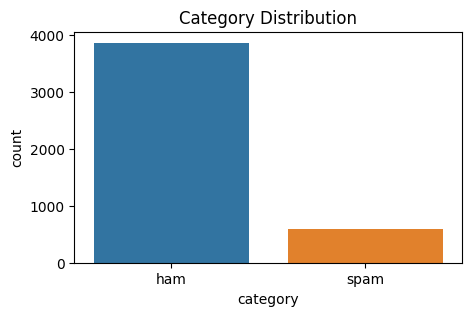

In [13]:
# Visualize Category Distribution

# Combine X_train and y_train
train_df = pd.DataFrame({'text': X_train, 'category': y_train})

# Plot category distribution
plt.figure(figsize=(5, 3))
sns.countplot(x='category', data=train_df)
plt.title('Category Distribution')
plt.show()

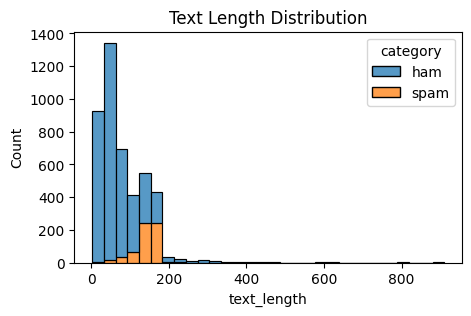

In [14]:
# Text Length Analysis

# Add a new column for text length
train_df['text_length'] = train_df['text'].apply(len)

# Plot text length distribution
plt.figure(figsize=(5, 3))
sns.histplot(data=train_df, x='text_length', hue='category', multiple='stack', bins=30)
plt.title('Text Length Distribution')
plt.show()

In [15]:
# Descriptive statistics of text length
print(train_df.groupby('category')['text_length'].describe())

           count        mean        std   min    25%    50%    75%    max
category                                                                 
ham       3859.0   70.829749  57.966498   2.0   33.0   52.0   91.0  910.0
spam       598.0  139.147157  28.887904  13.0  133.0  149.0  158.0  224.0


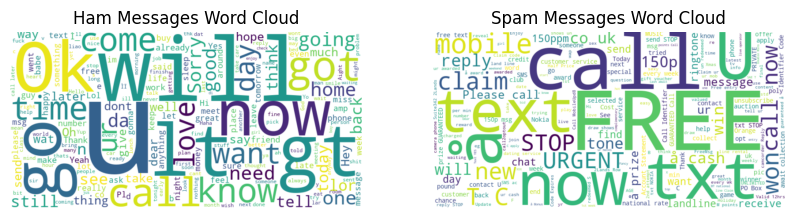

In [16]:
# Word Cloud for Text Visualization

# Generate word clouds for ham and spam messages
ham_words = ' '.join(train_df[train_df['category'] == 'ham']['text'])
spam_words = ' '.join(train_df[train_df['category'] == 'spam']['text'])

# Create word clouds
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Messages Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Messages Word Cloud')
plt.show()

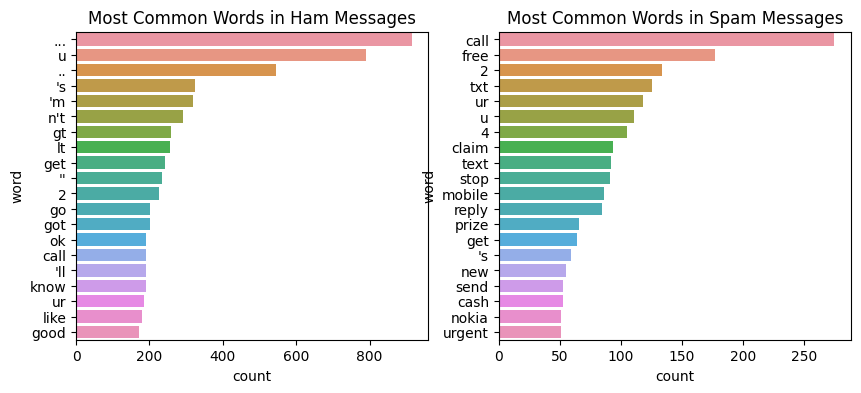

In [17]:
# Common Words in Ham and Spam Messages
# Define stop words and punctuation

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return ' '.join(tokens)

# Process texts for ham and spam messages
ham_tokens = train_df[train_df['category'] == 'ham']['text'].apply(preprocess_text)
spam_tokens = train_df[train_df['category'] == 'spam']['text'].apply(preprocess_text)

# Flatten the list of lists
ham_words = ' '.join(ham_tokens).split()
spam_words = ' '.join(spam_tokens).split()

# Get the most common words
ham_common_words = Counter(ham_words).most_common(20)
spam_common_words = Counter(spam_words).most_common(20)

# Plot the most common words
ham_common_df = pd.DataFrame(ham_common_words, columns=['word', 'count'])
spam_common_df = pd.DataFrame(spam_common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=ham_common_df)
plt.title('Most Common Words in Ham Messages')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=spam_common_df)
plt.title('Most Common Words in Spam Messages')
plt.show()

Feature engineering using TF-IDF Vectorization

In [18]:
# Vectorize the text data using TF-IDF

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_preprocessed = X_train.apply(preprocess_text)
X_test_preprocessed = X_test.apply(preprocess_text)

X_train_tfidf = tfidf.fit_transform(X_train_preprocessed)
X_test_tfidf = tfidf.transform(X_test_preprocessed)

Handle Class Imbalance using SMOTE for Oversampling

In [19]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Display new category distribution
print(pd.Series(y_train_resampled).value_counts())

category
ham     3859
spam    3859
Name: count, dtype: int64


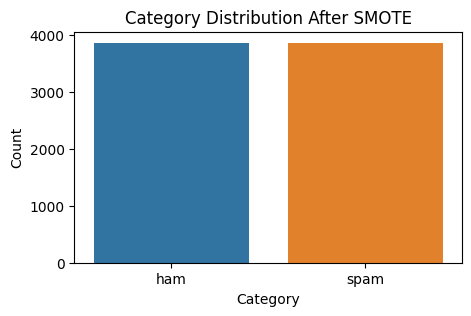

In [20]:
# Plot new category distribution
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train_resampled)
plt.title('Category Distribution After SMOTE')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Model Training and Evaluation with Cross-Validation and Hyperparameter Tuning

Best Parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'} 

Logistic Regression Performance:
Accuracy: 0.967713004484305
Precision: 0.864516129032258
Recall: 0.8993288590604027
F1 Score: 0.881578947368421
ROC AUC Score: 0.984520683090861
True Positives: 134
True Negatives: 945
False Positives: 21
False Negatives: 15




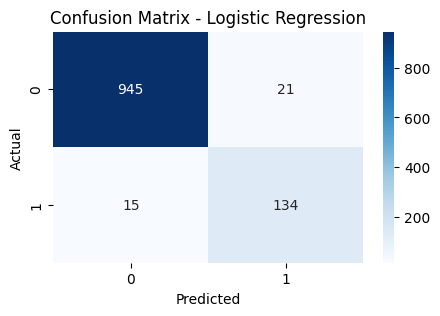

In [21]:
# Train and Evaluate Logistic Regression with L2 Regularization

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Initialize Logistic Regression model
lr = LogisticRegression()

# Perform Grid Search
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
best_model_lr = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_

print(f'Best Parameters for Logistic Regression: {best_params_lr} \n')

# Evaluate Logistic Regression
predictions_lr = best_model_lr.predict(X_test_tfidf)
proba_lr = best_model_lr.predict_proba(X_test_tfidf)[:, 1]
accuracy_lr = accuracy_score(y_test, predictions_lr)
precision_lr = precision_score(y_test, predictions_lr, pos_label='spam')
recall_lr = recall_score(y_test, predictions_lr, pos_label='spam')
f1_lr = f1_score(y_test, predictions_lr, pos_label='spam')
roc_auc_lr = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), proba_lr)
cm_lr = confusion_matrix(y_test, predictions_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

print('Logistic Regression Performance:')
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1 Score: {f1_lr}')
print(f'ROC AUC Score: {roc_auc_lr}')
print(f'True Positives: {tp_lr}')
print(f'True Negatives: {tn_lr}')
print(f'False Positives: {fp_lr}')
print(f'False Negatives: {fn_lr}')
print('\n')

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(5, 3))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best Parameters for MultinomialNB: {'alpha': 0.01} 

Naive Bayes Performance:
Best Parameters: {'alpha': 0.01}
Accuracy: 0.979372197309417
Precision: 0.92
Recall: 0.9261744966442953
F1 Score: 0.9230769230769231
ROC AUC Score: 0.9846735309238958
True Positives: 138
True Negatives: 954
False Positives: 12
False Negatives: 11




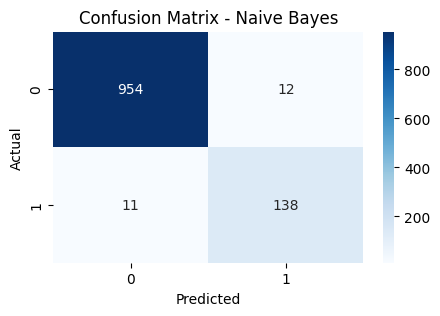

In [22]:
# Train and Evaluate Naive Bayes

# Define parameter grid for Naive Bayes
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize MultinomialNB model
nb = MultinomialNB()

# Perform Grid Search
grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='f1', n_jobs=-1)
grid_search_nb.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
best_model_nb = grid_search_nb.best_estimator_
best_params_nb = grid_search_nb.best_params_

print(f'Best Parameters for MultinomialNB: {best_params_nb} \n')

# Evaluate Naive Bayes
predictions_nb = best_model_nb.predict(X_test_tfidf)
proba_nb = best_model_nb.predict_proba(X_test_tfidf)[:, 1]
accuracy_nb = accuracy_score(y_test, predictions_nb)
precision_nb = precision_score(y_test, predictions_nb, pos_label='spam')
recall_nb = recall_score(y_test, predictions_nb, pos_label='spam')
f1_nb = f1_score(y_test, predictions_nb, pos_label='spam')
roc_auc_nb = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), proba_nb)
cm_nb = confusion_matrix(y_test, predictions_nb)
tn_nb, fp_nb, fn_nb, tp_nb = cm_nb.ravel()

print('Naive Bayes Performance:')
print(f'Best Parameters: {best_params_nb}')
print(f'Accuracy: {accuracy_nb}')
print(f'Precision: {precision_nb}')
print(f'Recall: {recall_nb}')
print(f'F1 Score: {f1_nb}')
print(f'ROC AUC Score: {roc_auc_nb}')
print(f'True Positives: {tp_nb}')
print(f'True Negatives: {tn_nb}')
print(f'False Positives: {fp_nb}')
print(f'False Negatives: {fn_nb}')
print('\n')

# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(5, 3))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best Parameters for SVM: {'C': 0.1, 'kernel': 'linear'} 

SVM Performance:
Accuracy: 0.9739910313901345
Precision: 0.9
Recall: 0.9060402684563759
F1 Score: 0.903010033444816
ROC AUC Score: 0.9886823127266663
True Positives: 135
True Negatives: 951
False Positives: 15
False Negatives: 14




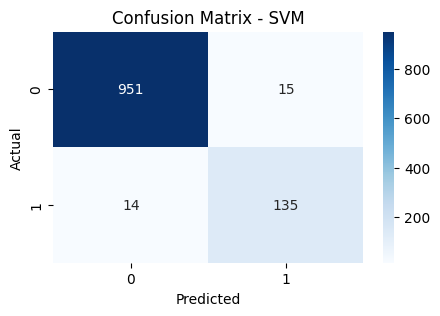

In [23]:
# Train and Evaluate SVM

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Initialize SVM model
svm = SVC(probability=True)

# Perform Grid Search
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
best_model_svm = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_

print(f'Best Parameters for SVM: {best_params_svm} \n')

# Evaluate SVM
predictions_svm = best_model_svm.predict(X_test_tfidf)
proba_svm = best_model_svm.predict_proba(X_test_tfidf)[:, 1]
accuracy_svm = accuracy_score(y_test, predictions_svm)
precision_svm = precision_score(y_test, predictions_svm, pos_label='spam')
recall_svm = recall_score(y_test, predictions_svm, pos_label='spam')
f1_svm = f1_score(y_test, predictions_svm, pos_label='spam')
roc_auc_svm = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), proba_svm)
cm_svm = confusion_matrix(y_test, predictions_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()

print('SVM Performance:')
print(f'Accuracy: {accuracy_svm}')
print(f'Precision: {precision_svm}')
print(f'Recall: {recall_svm}')
print(f'F1 Score: {f1_svm}')
print(f'ROC AUC Score: {roc_auc_svm}')
print(f'True Positives: {tp_svm}')
print(f'True Negatives: {tn_svm}')
print(f'False Positives: {fp_svm}')
print(f'False Negatives: {fn_svm}')
print('\n')

# Plot confusion matrix for SVM
plt.figure(figsize=(5, 3))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 100} 

Random Forest Performance:
Accuracy: 0.9766816143497757
Precision: 1.0
Recall: 0.825503355704698
F1 Score: 0.9044117647058824
ROC AUC Score: 0.9841906707240818
True Positives: 123
True Negatives: 966
False Positives: 0
False Negatives: 26




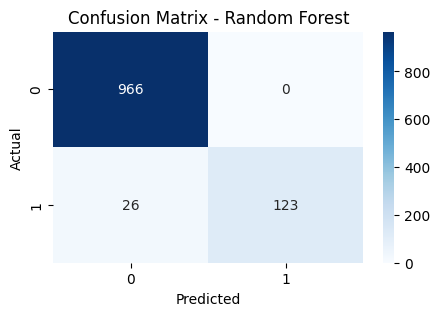

In [24]:
# Train and Evaluate Random Forest

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

# Initialize Random Forest model
rf = RandomForestClassifier()

# Train the model
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
best_model_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

print(f'Best Parameters for Random Forest: {best_params_rf} \n')

# Evaluate Random Forest
predictions_rf = best_model_rf.predict(X_test_tfidf)
proba_rf = best_model_rf.predict_proba(X_test_tfidf)[:, 1]
accuracy_rf = accuracy_score(y_test, predictions_rf)
precision_rf = precision_score(y_test, predictions_rf, pos_label='spam')
recall_rf = recall_score(y_test, predictions_rf, pos_label='spam')
f1_rf = f1_score(y_test, predictions_rf, pos_label='spam')
roc_auc_rf = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), proba_rf)
cm_rf = confusion_matrix(y_test, predictions_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print('Random Forest Performance:')
print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1 Score: {f1_rf}')
print(f'ROC AUC Score: {roc_auc_rf}')
print(f'True Positives: {tp_rf}')
print(f'True Negatives: {tn_rf}')
print(f'False Positives: {fp_rf}')
print(f'False Negatives: {fn_rf}')
print('\n')

# Plot confusion matrix for Random Forest
plt.figure(figsize=(5, 3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Voting Classifier Performance:
Accuracy: 0.9847533632286996
Precision: 0.9647887323943662
Recall: 0.9194630872483222
F1 Score: 0.9415807560137458
ROC AUC Score: 0.992454875151111
True Positives: 137
True Negatives: 961
False Positives: 5
False Negatives: 12




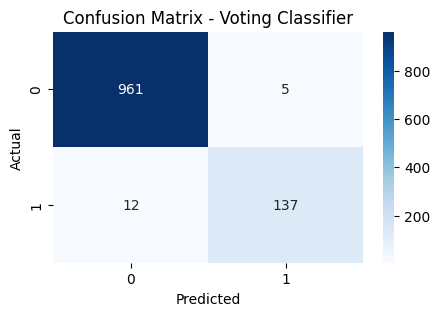

In [25]:
# Train and Evaluate Voting Classifier

# Initialize Voting Classifier
voting_clf = VotingClassifier(estimators=[('lr', best_model_lr), ('nb', best_model_nb), 
                                          ('svm', best_model_svm), ('rf', best_model_rf)], voting='soft')
voting_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate Voting Classifier
predictions_vc = voting_clf.predict(X_test_tfidf)
proba_vc = voting_clf.predict_proba(X_test_tfidf)[:, 1]
accuracy_vc = accuracy_score(y_test, predictions_vc)
precision_vc = precision_score(y_test, predictions_vc, pos_label='spam')
recall_vc = recall_score(y_test, predictions_vc, pos_label='spam')
f1_vc = f1_score(y_test, predictions_vc, pos_label='spam')
roc_auc_vc = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), proba_vc)
cm_vc = confusion_matrix(y_test, predictions_vc)
tn_vc, fp_vc, fn_vc, tp_vc = cm_vc.ravel()

print('Voting Classifier Performance:')
print(f'Accuracy: {accuracy_vc}')
print(f'Precision: {precision_vc}')
print(f'Recall: {recall_vc}')
print(f'F1 Score: {f1_vc}')
print(f'ROC AUC Score: {roc_auc_vc}')
print(f'True Positives: {tp_vc}')
print(f'True Negatives: {tn_vc}')
print(f'False Positives: {fp_vc}')
print(f'False Negatives: {fn_vc}')
print('\n')

# Plot confusion matrix for Voting Classifier
plt.figure(figsize=(5, 3))
sns.heatmap(cm_vc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# Compare Model Performance
model_names = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Voting Classifier']
accuracies = [accuracy_lr, accuracy_nb, accuracy_svm, accuracy_rf, accuracy_vc]
precisions = [precision_lr, precision_nb, precision_svm, precision_rf, precision_vc]
recalls = [recall_lr, recall_nb, recall_svm, recall_rf, recall_vc]
f1_scores = [f1_lr, f1_nb, f1_svm, f1_rf, f1_vc]
roc_aucs = [roc_auc_lr, roc_auc_nb, roc_auc_svm, roc_auc_rf, roc_auc_vc]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC Score': roc_aucs
})

print(comparison_df)

                 Model  Accuracy  Precision    Recall  F1 Score  ROC AUC Score
0  Logistic Regression  0.967713   0.864516  0.899329  0.881579       0.984521
1          Naive Bayes  0.979372   0.920000  0.926174  0.923077       0.984674
2                  SVM  0.973991   0.900000  0.906040  0.903010       0.988682
3        Random Forest  0.976682   1.000000  0.825503  0.904412       0.984191
4    Voting Classifier  0.984753   0.964789  0.919463  0.941581       0.992455


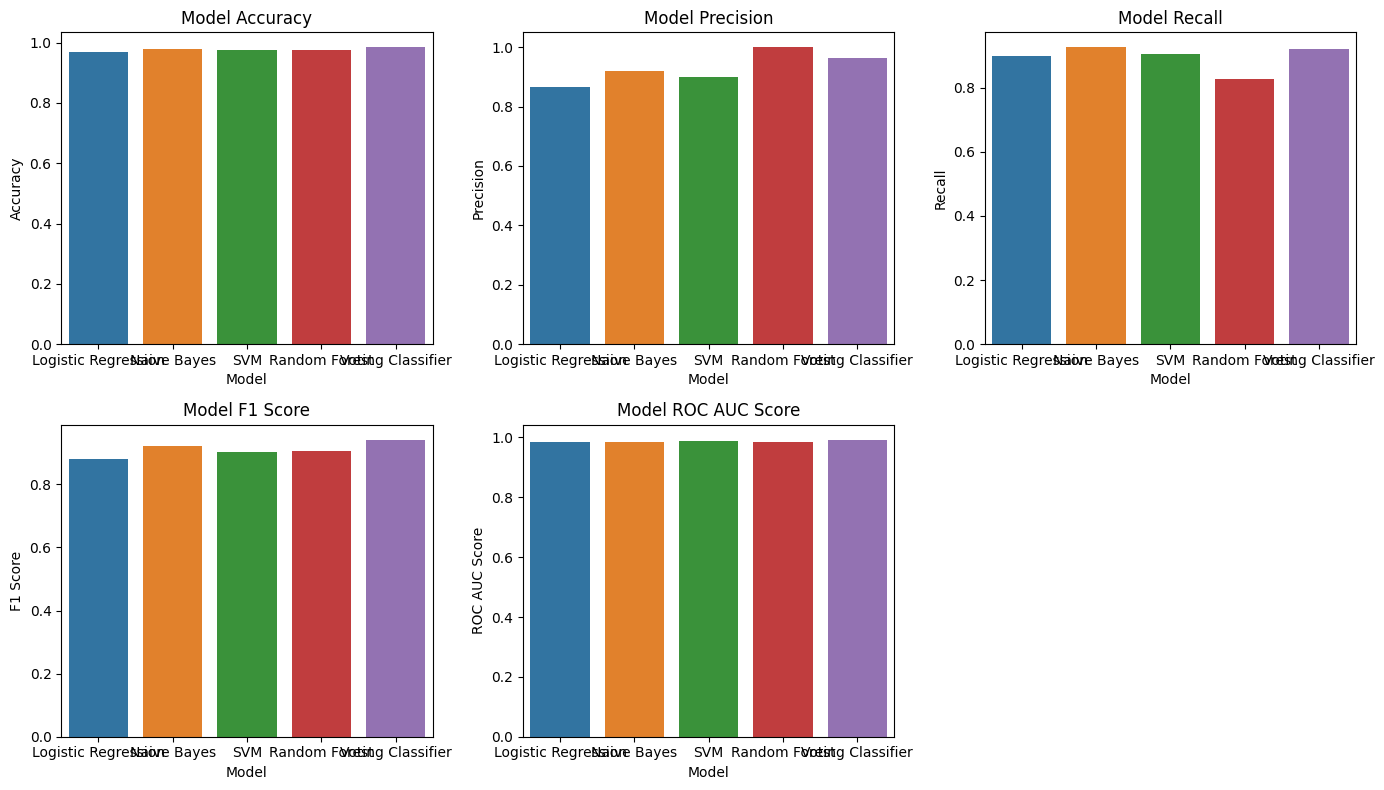

In [27]:
# Plot comparison of models
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.subplot(2, 3, 2)
sns.barplot(x='Model', y='Precision', data=comparison_df)
plt.title('Model Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

plt.subplot(2, 3, 3)
sns.barplot(x='Model', y='Recall', data=comparison_df)
plt.title('Model Recall')
plt.xlabel('Model')
plt.ylabel('Recall')

plt.subplot(2, 3, 4)
sns.barplot(x='Model', y='F1 Score', data=comparison_df)
plt.title('Model F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')

plt.subplot(2, 3, 5)
sns.barplot(x='Model', y='ROC AUC Score', data=comparison_df)
plt.title('Model ROC AUC Score')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')

plt.tight_layout()
plt.show()

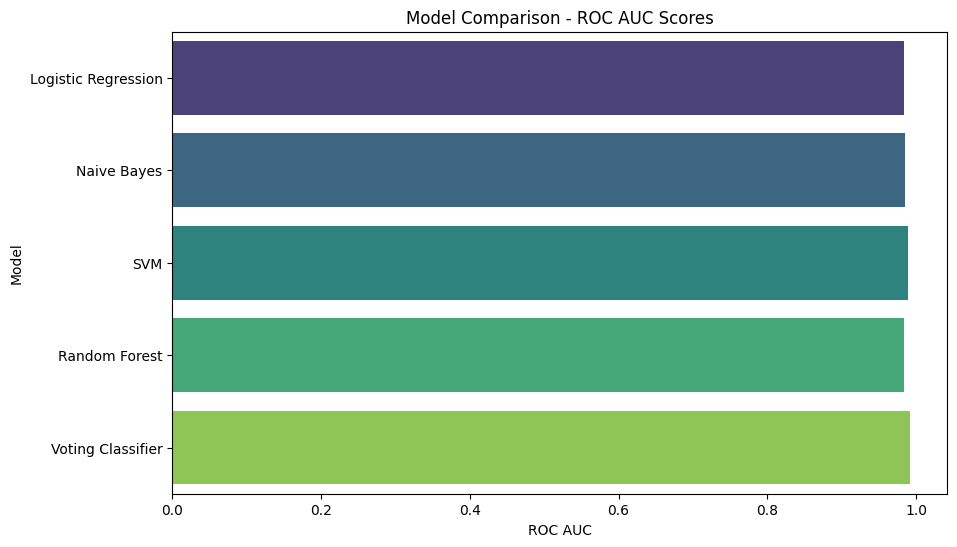

In [28]:
# Compare Model Performance

# Additional ROC AUC Score Comparison
roc_auc_comparison_df = pd.DataFrame([
    {'Model': 'Logistic Regression', 'ROC AUC': roc_auc_lr},
    {'Model': 'Naive Bayes', 'ROC AUC': roc_auc_nb},
    {'Model': 'SVM', 'ROC AUC': roc_auc_svm},
    {'Model': 'Random Forest', 'ROC AUC': roc_auc_rf},
    {'Model': 'Voting Classifier', 'ROC AUC': roc_auc_vc},
])

plt.figure(figsize=(10, 6))
sns.barplot(x='ROC AUC', y='Model', data=roc_auc_comparison_df, palette='viridis')
plt.title('Model Comparison - ROC AUC Scores')
plt.show()

In [29]:
# Function to predict if a message is spam or not
def predict_message(message):
    preprocessed_message = preprocess_text(message)
    message_tfidf = tfidf.transform([preprocessed_message])
    prediction = voting_clf.predict(message_tfidf)[0]
    return prediction

# Example usage of predict_message function
message = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
prediction = predict_message(message)
print(f"Predicted category for message: {prediction}")

Predicted category for message: spam
